<a href="https://colab.research.google.com/github/MikailINTech/DeepGo/blob/main/DeepGo_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DeepGo

/content/drive/MyDrive/DeepGo


In [ ]:
#[1]*10**10

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras import layers 
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D,Reshape
import matplotlib.pyplot as plt
import gc

import golois
import sys
sys.path.append('/content/drive/MyDrive/DeepGo')

In [ ]:
planes = 31
moves = 361
N = 10000
epochs = 50
batch = 64
filters = 256
expand = filters*4

input_data = np.random.randint(2, size=(N, 19, 19, planes))
input_data = input_data.astype ('float32')

policy = np.random.randint(moves, size=(N,))
policy = keras.utils.to_categorical (policy)

value = np.random.randint(2, size=(N,))
value = value.astype ('float32')

end = np.random.randint(2, size=(N, 19, 19, 2))
end = end.astype ('float32')

groups = np.zeros((N, 19, 19, 1))
groups = groups.astype ('float32')

print ("getValidation", flush = True)
golois.getValidation (input_data, policy, value, end)

getValidation


In [ ]:
def SE_Block(t,filters,ratio=4):
  filters=t.shape[-1]
  se_shape= (1,1,filters)
  se = layers.GlobalAveragePooling2D()(t)
  se = layers.Reshape(se_shape)(se)
  se = layers.Dense(filters // ratio,use_bias=False)(se)
  se = layers.Activation('ReLU')(se)
  se = layers.Dense(filters, use_bias=False)(se)
  se = layers.Activation(tf.keras.activations.swish)(se)
  x = layers.multiply([t,se])

  return t


def bottleneck_block(x, kernel_size,expand, squeeze,activation=tf.keras.activations.swish,SE=True):
    m = layers.Conv2D(expand, (1,1), kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(x)
    m = layers.Activation(activation)(m)
    m = layers.BatchNormalization()(m)
    m = layers.Activation(activation)(m)

    m1= layers.DepthwiseConv2D((kernel_size, kernel_size), padding='same', kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(m)
    m2= layers.DepthwiseConv2D((3,3), padding='same',kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(m)
    m3= layers.DepthwiseConv2D((5,5),padding='same',kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(m)

    m1 = layers.BatchNormalization()(m1)
    m1 = layers.Activation(activation)(m1)
    m2 = layers.BatchNormalization()(m2)
    m2 = layers.Activation(activation)(m2)
    m3 = layers.BatchNormalization()(m3)
    m3 = layers.Activation(activation)(m3)
    m = layers.Concatenate(axis=-1)([m1,m2,m3])
    if SE:
      m = SE_Block(m,expand)
    m = layers.Conv2D(squeeze, (1,1), kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(m)
    m = layers.BatchNormalization()(m)
    if squeeze == x.shape[-1]:
      m = layers.Add()([m, x])
    return m

In [ ]:
def buildModel(batch,epochs,filters,expand):
  input = keras.Input(shape=(19, 19, planes), name='board')
  x = layers.Conv2D(16, (3, 3), padding='same',activation=tf.keras.activations.swish)(input)

  x = bottleneck_block(x,3,expand=16,squeeze=16,activation='ReLU')
  x = bottleneck_block(x,3,expand=60,squeeze=20,activation='ReLU',SE=False)
  x = bottleneck_block(x,3,expand=80,squeeze=20,activation='ReLU',SE=False)
  x = bottleneck_block(x,5,expand=90,squeeze=40,activation='ReLU',SE=False)
  x = bottleneck_block(x,5,expand=240,squeeze=60)
  x = bottleneck_block(x,5,expand=240,squeeze=60)
  x = bottleneck_block(x,5,expand=120,squeeze=40)
  x = bottleneck_block(x,3,expand=240,squeeze=60)
  x = bottleneck_block(x,3,expand=240,squeeze=60)
  x = bottleneck_block(x,5,expand=120,squeeze=50)
  x = bottleneck_block(x,5,expand=320,squeeze=80)
  x = bottleneck_block(x,5,expand=560,squeeze=90)
  x = bottleneck_block(x,5,expand=560,squeeze=90)

  policy_head = layers.Conv2D(90,1, 1, padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
  policy_head = layers.BatchNormalization()(policy_head)
  policy_head = layers.Activation(tf.keras.activations.swish)(policy_head)
  #policy_head = layers.AveragePooling2D()(policy_head)
  policy_head = layers.Conv2D(1, 1, padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(policy_head)
  policy_head = layers.Activation(tf.keras.activations.swish)(policy_head)
  policy_head = layers.Conv2D(1, 1, padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(policy_head)
  policy_head = layers.Flatten()(policy_head)
  policy_head = layers.Activation('softmax', name='policy')(policy_head)
  
  
  
  value_head = layers.Conv2D(1, 1, padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
  value_head = layers.Activation('ReLU')(value_head)
  value_head = layers.GlobalAveragePooling2D()(value_head)
  value_head = layers.Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)

  #policy_head = layers.Conv2D(120,1, 1, padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
  #policy_head = layers.BatchNormalization()(policy_head)
  #policy_head = layers.Activation(tf.keras.activations.swish)(policy_head)
  #policy_head = layers.AveragePooling2D(pool_size=(19, 19), strides=None, padding="same")(policy_head)
  #policy_head = layers.Conv2D(480,1, 1, padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(policy_head)
  #policy_head = layers.Activation(tf.keras.activations.swish)(policy_head)
  #policy_head = layers.Conv2D(19*19,1, 1, padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(policy_head)
  #policy_head = layers.Flatten()(policy_head)
  #policy_head = layers.Activation('softmax', name='policy')(policy_head)
  
  
  
  #value_head = layers.Conv2D(120,1, 1, padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
  #value_head = layers.BatchNormalization()(value_head)
  #value_head = layers.Activation('ReLU')(value_head)
  #value_head = layers.AveragePooling2D(pool_size=(19, 19), strides=None, padding="same")(value_head)
  #value_head = layers.Conv2D(480,1, 1, padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(value_head)
  #value_head = layers.Activation(tf.keras.activations.swish)(value_head)
  #value_head = layers.Conv2D(1,1, 1, padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(value_head)
  #value_head = layers.Flatten()(value_head)
  #value_head = layers.Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)
  
  model = keras.Model(inputs=input, outputs=[policy_head, value_head])

  return model

model=buildModel(batch,epochs,filters,expand)

model.summary ()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board (InputLayer)             [(None, 19, 19, 31)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_602 (Conv2D)            (None, 19, 19, 16)   4480        ['board[0][0]']                  
                                                                                                  
 conv2d_603 (Conv2D)            (None, 19, 19, 16)   256         ['conv2d_602[0][0]']             
                                                                                                  
 activation_1661 (Activation)   (None, 19, 19, 16)   0           ['conv2d_603[0][0]']      

In [ ]:
optimizer=tf.keras.optimizers.Nadam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam"
)


In [ ]:
model.compile(optimizer=optimizer,
              loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
              loss_weights={'policy' : 1.0, 'value' : 1.0},
              metrics={'policy': 'categorical_accuracy', 'value': 'mse'})

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from keras import backend as K
filepath = '/content/drive/MyDrive/DeepGo/Mikail_DUZENLI_Mixed_architecture_VF.h5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='policy_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
history_acc=[]
history_lr=[]
history_MSE=[]

In [ ]:
np.set_printoptions(threshold=np.inf)

In [ ]:
T_max=501
eta_max=1e-3
eta_min=1e-7

for epoch in range (1, T_max):
    print ('epoch ' + str (epoch))
    golois.getBatch(input_data, policy, value, end, groups, epoch * N)
    lr = eta_min + (eta_max - eta_min) * (1 + np.cos(np.pi * epoch / T_max)) / 2
    K.set_value(model.optimizer.learning_rate, lr)
    history = model.fit(input_data,
                        {'policy': policy, 'value': value}, 
                        epochs=1, batch_size=batch,callbacks=callbacks)
    
    if (epoch % 5 == 0):
        gc.collect ()
    if (epoch % 2 == 0):
        golois.getValidation (input_data, policy, value, end)
        val = model.evaluate (input_data,
                              [policy, value], verbose = 0, batch_size=batch)
        print('------------------------------------------------------------------------------------------------------------')
        print (f"Loss {val[0]:.5f} | Policy loss {val[1]:.5f} | Value loss {val[2]:.5f} | Policy acc {val[3]:.5f} | Value MSE {val[4]:.5f} ")
        print('------------------------------------------------------------------------------------------------------------')
        history_acc.append(val[3])
        history_lr.append(lr)
        history_MSE.append(val[4])

epoch 1
157/157 [==============================] - ETA: 0s - loss: 6.7903 - policy_loss: 5.8585 - value_loss: 0.7005 - policy_categorical_accuracy: 0.0034 - value_mse: 0.1227
Epoch 00001: policy_loss improved from inf to 5.85848, saving model to /content/drive/MyDrive/DeepGo/Mikail_DUZENLI_Mixed_architecture_VF.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


157/157 [==============================] - 54s 230ms/step - loss: 6.7903 - policy_loss: 5.8585 - value_loss: 0.7005 - policy_categorical_accuracy: 0.0034 - value_mse: 0.1227
epoch 2
157/157 [==============================] - ETA: 0s - loss: 6.4611 - policy_loss: 5.5428 - value_loss: 0.6932 - policy_categorical_accuracy: 0.0173 - value_mse: 0.1189
Epoch 00001: policy_loss improved from 5.85848 to 5.54276, saving model to /content/drive/MyDrive/DeepGo/Mikail_DUZENLI_Mixed_architecture_VF.h5
157/157 [==============================] - 36s 230ms/step - loss: 6.4611 - policy_loss: 5.5428 - value_loss: 0.6932 - policy_categorical_accuracy: 0.0173 - value_mse: 0.1189
------------------------------------------------------------------------------------------------------------
Loss 6.80437 | Policy loss 5.88974 | Value loss 0.69277 | Policy acc 0.00110 | Value MSE 0.11721 
------------------------------------------------------------------------------------------------------------
epoch 3
157/157 

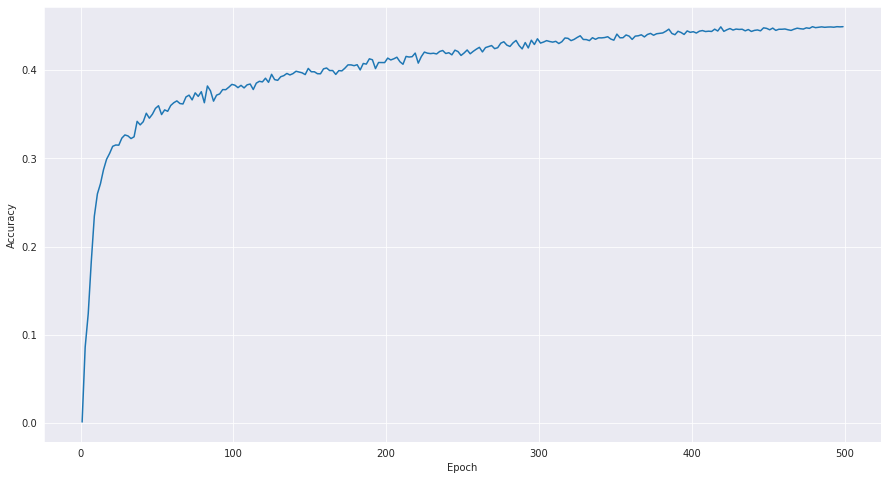

In [ ]:
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize=(15,8))
plt.plot(np.arange(1,501,2), history_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

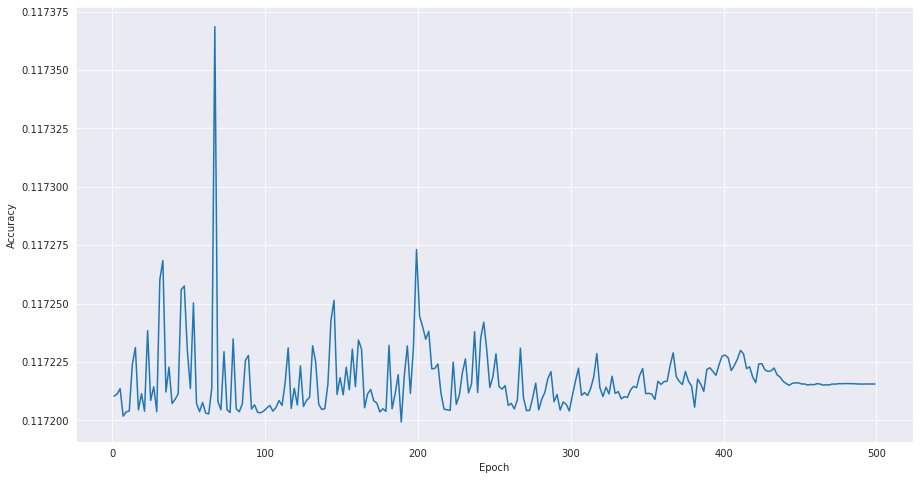

In [ ]:
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize=(15,8))
plt.plot(np.arange(1,501,2), history_MSE)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
raise SystemExit("Stop right there!")

#**Load and test a model here**

In [ ]:
filepath = '//content/drive/MyDrive/DeepGo/Mikail_Mixed_architecture_V4.h5'

In [ ]:
model = keras.models.load_model(filepath)

In [ ]:
golois.getValidation (input_data, policy, value, end)
val = model.evaluate (input_data,[policy, value], verbose = 0, batch_size=batch)
print (f"Loss {val[0]:.5f} | Policy loss {val[1]:.5f} | Value loss {val[2]:.5f} | Policy acc {val[3]:.5f} | Value MSE {val[4]:.5f} ")

In [ ]:
import os

def list_files(dir):
  best_accuracy=0
  for mods, dirs, b in os.walk(dir):
    print(f'mods {mods}')
    for mod in mods:
            print()
            break
            model=keras.models.load_model(mod)
            val = model.evaluate (input_data,[policy, value], verbose = 0, batch_size=batch)
            print (f"For model {mod} we have : Loss {val[0]:.5f} | Policy loss {val[1]:.5f} | Value loss {val[2]:.5f} | Policy acc {val[3]:.5f} | Value MSE {val[4]:.5f} ")

            if best_accuracy < val[3]:
              best_accuracy=val[3]
              best_model = model
              best_model_dir = mod

  print(f'Best model is {best_model_dir}')
  return best_model